# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

## <font color="red">*Pitch Your Project*</font>

<font color="red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

# ***What?*** 

I plan to analyze news articles on US news media sites to learn about the sentiment difference in US media's news articles reporting domestic news and foreign news. Here the social actors will be the news media companies, the readers and the ones that are being reported (part of the news). In particular, I want to learn about how news media companies might report news with different sentiment. The social world would be the global community where the news media companies reports and the readers react to the news. The social game would be the news media companies' output of their version of 'fact' to the general public.

## ***Why?***

The assumption is that the US news media companies would report more postively when reporting domestic news, but more negatively when reporting foreign news. The social game, world, and actors are already discussed above. The news articles on the news media companies' sites are the first source of learning how the media want to output the news. However, their sites are not as influential as their social media accounts, e.g. twitter/instagram accounts. Twitter and instagram has more strict word count restriction, and the news are more likely to be seen as the social media is becoming the main media of information. It would also be good if I can scrape similar data from other countries, e.g. China, Japan, or India, and analyze how those countries report news. This would allow me to compare if news media in countries with different politics system (which can affect media) report news to the general public in different ways.

## ***How?***

I will coolect the news for the U.S, China, India, Korea, Japan, and the U.K by crawling from CNN, NBC, and ABC. In the first study, I will conduct topic analysis that group the news into different topics. Within each topic, I will conduct sentiment analysis. In the second study, I will focus on country names in the news articles. For the international news, there can be many countries involved. In that case, it can be difficult to decide the sentiment is postive or negative in terms of which country involved. I plan to conduct sentiment analysis for different combinations of countries first, then see if there is a pattern, i.e. correlation between sentiment and combinations. In order to cross valid, I plan to train doc2vec models for each combination, and I will check similarity between different combinations to see if the similarities align with the sentiment analysis result.

## <font color="red">*Pitch Your Sample*</font>

<font color="red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

## ***Which (words)?***
The social game would be the 3 news media companies' output of their version of 'fact' to the general community that reads English. My sample research design contains different steps. The first step is like a pilot study, as topic analysis can be unreliable. The second study utilizes different combinations of country names, which can be a great factor in how news media companies report news. Crawling from news media companies' websites might not be enough, as they may report news differently on soical media like twitter or instagram. I would like to see if there are existing datasets of news on twitter, instagram, reddit, or facebook. Also, it would be good to integrate more advanced SOTA language models in sentiment analysis and other pipelines of the study.

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [3]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [4]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Kennedy,../data/grimmerPressReleases\Kennedy\01Apr2005...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
10,Kennedy,../data/grimmerPressReleases\Kennedy\01Dec2005...,FOR IMMEDIATE RELEASE Washington ...
20,Kennedy,../data/grimmerPressReleases\Kennedy\01Feb2006...,FOR IMMEDIATE RELEASE Fact sheet...
30,Kennedy,../data/grimmerPressReleases\Kennedy\01Feb2007...,FOR IMMEDIATE RELEASE Washington ...
40,Kennedy,../data/grimmerPressReleases\Kennedy\01Jun2007...,FOR IMMEDIATE RELEASE BOSTON MA Se...
50,Kennedy,../data/grimmerPressReleases\Kennedy\01Mar2007...,FOR IMMEDIATE RELEASE Washington ...
60,Kennedy,../data/grimmerPressReleases\Kennedy\01May2007...,FOR IMMEDIATE RELEASE The President ...
70,Kennedy,../data/grimmerPressReleases\Kennedy\01Nov2007...,FOR IMMEDIATE RELEASE Washington DC...
80,Kennedy,../data/grimmerPressReleases\Kennedy\02Aug2006...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
90,Kennedy,../data/grimmerPressReleases\Kennedy\02Feb2005...,FOR IMMEDIATE RELEASE The Preside...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,category,filePath,text,tokenized_sents,normalized_sents
0,Kennedy,../data/grimmerPressReleases\Kennedy\01Apr2005...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
10,Kennedy,../data/grimmerPressReleases\Kennedy\01Dec2005...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, d, c, today,..."
20,Kennedy,../data/grimmerPressReleases\Kennedy\01Feb2006...,FOR IMMEDIATE RELEASE Fact sheet...,"[[FOR, IMMEDIATE, RELEASE, Fact, sheets, on, B...","[[immediate, release, fact, sheets, bush, s, p..."
30,Kennedy,../data/grimmerPressReleases\Kennedy\01Feb2007...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, d, c, today,..."
40,Kennedy,../data/grimmerPressReleases\Kennedy\01Jun2007...,FOR IMMEDIATE RELEASE BOSTON MA Se...,"[[FOR, IMMEDIATE, RELEASE, BOSTON, MA, Senator...","[[immediate, release, boston, ma, senator, edw..."
50,Kennedy,../data/grimmerPressReleases\Kennedy\01Mar2007...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Tod...","[[immediate, release, washington, dc, today, s..."
60,Kennedy,../data/grimmerPressReleases\Kennedy\01May2007...,FOR IMMEDIATE RELEASE The President ...,"[[FOR, IMMEDIATE, RELEASE, The, President, is,...","[[immediate, release, president, wrong, veto, ..."
70,Kennedy,../data/grimmerPressReleases\Kennedy\01Nov2007...,FOR IMMEDIATE RELEASE Washington DC...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Sen...","[[immediate, release, washington, dc, senators..."
80,Kennedy,../data/grimmerPressReleases\Kennedy\02Aug2006...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release], [im..."
90,Kennedy,../data/grimmerPressReleases\Kennedy\02Feb2005...,FOR IMMEDIATE RELEASE The Preside...,"[[FOR, IMMEDIATE, RELEASE, The, President, gav...","[[immediate, release, president, gave, effecti..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [7]:
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum(), sg=0)

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [8]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([ 1.1142359 ,  0.45409223, -0.31696692, -2.068675  , -1.408294  ,
       -0.5308691 , -0.6914519 , -0.9583863 ,  0.74570066, -2.89912   ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [9]:
senReleasesW2V.wv.syn0

array([[ 1.33366954e+00, -7.10408926e-01, -4.49628592e-01, ...,
         2.20421329e-01,  3.98044109e-01, -9.58983362e-01],
       [-2.93874770e-01, -9.43469226e-01,  1.85587430e+00, ...,
        -3.27696562e-01,  1.05788553e+00,  1.06144540e-01],
       [-1.12463892e-01,  3.07534456e-01, -2.45679557e-01, ...,
        -3.73889506e-01,  2.69333935e+00,  2.58100450e-01],
       ...,
       [-1.56964120e-02, -5.72343282e-02,  1.57829840e-02, ...,
         3.09128631e-02,  1.02267586e-01, -4.29849960e-02],
       [ 1.75151485e-03, -4.82866121e-03,  3.51254977e-02, ...,
         1.34421587e-02,  6.14194088e-02, -4.65130471e-02],
       [ 1.08512081e-02, -5.64938821e-02, -2.75242031e-02, ...,
         1.73958782e-02,  1.52564153e-01, -1.03889043e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [12]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [13]:
senReleasesW2V.most_similar('president')

[('administration', 0.8213303685188293),
 ('presidents', 0.7475935220718384),
 ('administrations', 0.7046786546707153),
 ('responds', 0.5978522300720215),
 ('cheney', 0.5779062509536743),
 ('george', 0.5504052042961121),
 ('sims', 0.5476062297821045),
 ('rollback', 0.5423224568367004),
 ('ronald', 0.5366021990776062),
 ('kenna', 0.5140087604522705)]

In [14]:
senReleasesW2V.most_similar('war')

[('wars', 0.6833310127258301),
 ('quagmire', 0.6555983424186707),
 ('disobedience', 0.641502857208252),
 ('chaos', 0.6409823894500732),
 ('afghanistan', 0.6284763813018799),
 ('battle', 0.6153467297554016),
 ('invade', 0.610712468624115),
 ('sight', 0.6097722053527832),
 ('excuse', 0.585858941078186),
 ('insurgency', 0.5851901769638062)]

Find which word least matches the others within a word set (cosine similarity):

In [15]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [16]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.6879757046699524),
 ('veto', 0.6555712223052979),
 ('bushs', 0.6495671272277832),
 ('signed', 0.62743079662323),
 ('vetoed', 0.6242855191230774),
 ('signature', 0.6215943098068237),
 ('vetoes', 0.6088500022888184),
 ('proposing', 0.6036285161972046),
 ('lyndon', 0.6003055572509766),
 ('blocked', 0.5925166606903076)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [17]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [19]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [20]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 1.3336695 , -0.7104089 , -0.4496286 , ...,  0.22042133,
         0.3980441 , -0.95898336],
       [-0.29387477, -0.9434692 ,  1.8558743 , ..., -0.32769656,
         1.0578855 ,  0.10614454],
       [-0.11246389,  0.30753446, -0.24567956, ..., -0.3738895 ,
         2.6933393 ,  0.25810045],
       ...,
       [-0.3225051 ,  0.68222326,  1.5970343 , ..., -0.8390382 ,
         1.5892731 , -1.6573722 ],
       [-0.93125063, -0.14346685,  1.5259774 , ...,  0.25417024,
         1.1031818 , -0.4653253 ],
       [-0.02639493,  0.5963816 ,  0.9311107 , ...,  1.5767635 ,
         1.785667  ,  1.1305115 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [21]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

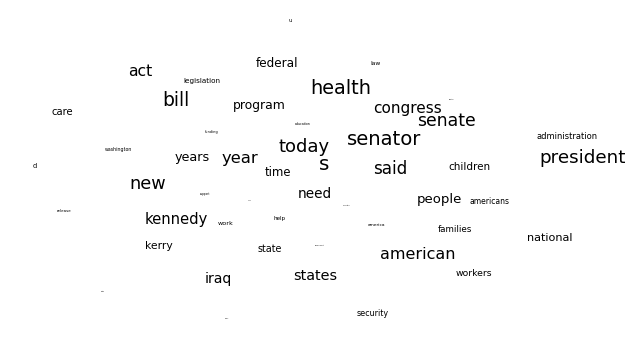

In [22]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [23]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [24]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [25]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [26]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [27]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [28]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## Adding more context - FastText

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText ([Bojanowski et al. 2017](https://arxiv.org/abs/1607.04606)), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents. 

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [Google Drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing). 

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [32]:
import fasttext

In [35]:
# Replace with the path for where you have placed the 'fil9' file.
file_address = "../data/fil9" 

In [36]:
model = fasttext.train_unsupervised(file_address)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [37]:
model.words

['the',
 'of',
 'and',
 'in',
 'a',
 'to',
 'is',
 'The',
 'are',
 'for',
 'was',
 'as',
 'with',
 'by',
 'from',
 'that',
 'on',
 'or',
 'at',
 'an',
 'his',
 'have',
 'which',
 'it',
 'In',
 'be',
 'age',
 'also',
 'he',
 'has',
 'were',
 'not',
 'who',
 'had',
 'population',
 'this',
 'but',
 'km',
 'other',
 'there',
 'their',
 'one',
 'under',
 'A',
 'more',
 '18',
 'its',
 'all',
 'living',
 'first',
 'two',
 'income',
 'median',
 'been',
 'It',
 'out',
 'total',
 'United',
 'can',
 'For',
 'years',
 'they',
 'This',
 'He',
 'into',
 'There',
 'most',
 'city',
 'average',
 'As',
 'such',
 'used',
 '65',
 'some',
 'up',
 'no',
 'mi.',
 'New',
 'those',
 'many',
 'only',
 'made',
 'after',
 'than',
 'would',
 'when',
 'American',
 'family',
 'area',
 'any',
 'every',
 'States',
 'town',
 '100',
 'known',
 'links',
 'External',
 'her',
 'about',
 'County,',
 'located',
 'size',
 'below',
 'may',
 'between',
 'over',
 'time',
 '1',
 'families',
 'density',
 'line.',
 'called',
 'hous

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [38]:
model.get_word_vector("the")

array([-0.2907569 ,  0.3186912 , -0.11512089,  0.16044265,  0.37212583,
        0.3125212 , -0.43234628, -0.03114643,  0.12667668, -0.17015663,
       -0.18907543,  0.14739954,  0.03132249, -0.18045506, -0.41199794,
        0.04500555,  0.03086831,  0.02473721, -0.29048738, -0.02536454,
        0.41852966, -0.08957551, -0.02614457,  0.00127006,  0.03438582,
       -0.0731526 , -0.02712776,  0.07547181,  0.08421738, -0.01347595,
        0.21220344, -0.36736116,  0.01666515, -0.11117822, -0.38947982,
        0.02427704,  0.09676908, -0.03553605,  0.23412551, -0.05375164,
        0.36747018,  0.40217718, -0.06217264, -0.08832726,  0.25728008,
       -0.2582084 ,  0.0693193 ,  0.16647446, -0.26402882, -0.1252601 ,
        0.17105108,  0.01611086,  0.14146207, -0.04038717,  0.2690295 ,
        0.34427112, -0.07231124,  0.12762842, -0.4422074 , -0.20801274,
       -0.06364949,  0.11888145, -0.02853027,  0.3086351 ,  0.25438938,
        0.07690556,  0.0751505 , -0.00259701, -0.1268459 ,  0.20

In [44]:
model.save_model("C:/Users/Rando/Desktop/Files/UChicago_Winter_2022/Content/Homework-Notebooks/week-4/fil9.bin")

In [ ]:
# when we want to use the model again
# model = fasttext.load_model("result/fil9.bin")

Let's now print some vectors.

In [45]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

[array([-0.5858139 ,  0.68629885, -0.5148218 ,  0.6258294 ,  0.39847898,
        -0.11801739, -0.11935867,  0.25715643,  0.22442743,  0.37202755,
        -0.13034487,  0.19826195,  0.054717  , -0.15621564, -0.59047776,
         0.32903332,  0.7078163 ,  0.27387768,  0.09843986, -0.28738517,
        -0.8305285 , -0.20890914,  0.7612611 ,  0.6789991 , -0.33028066,
         0.33628678,  0.6643891 ,  0.61188   , -0.5776847 , -0.53875625,
         0.23504646,  0.10028313, -0.9630126 ,  0.38130888,  0.11398508,
        -0.14639872,  0.18801469,  0.5553857 ,  0.38408485,  0.18075864,
         0.04243635,  0.24296074,  0.5026148 ,  0.5364384 ,  0.2807427 ,
        -0.47483623,  0.2778781 ,  0.71262   ,  0.18129486, -0.1893874 ,
         0.8711555 , -0.0021167 ,  0.18376195, -0.20104797,  0.0294372 ,
         0.21529566, -0.14855893, -0.1762785 , -0.078422  , -0.13333693,
         0.8210652 ,  0.17164151, -0.5337764 ,  0.1900199 ,  0.13253443,
         0.32308477,  0.2929984 , -0.100632  ,  0.3

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [46]:
model.get_word_vector("enviroment")

array([-7.33052962e-04,  2.45026588e-01, -6.66428059e-02, -1.74904868e-01,
        4.22079146e-01,  1.59751371e-01, -2.03882735e-02,  8.28485787e-02,
        3.91733855e-01, -2.69100308e-01, -1.32858828e-01, -1.04595482e-01,
        2.44527161e-02, -2.86928862e-02,  6.92427233e-02, -1.56102955e-01,
       -6.11776263e-02, -3.63252237e-02, -1.89573184e-01, -2.14283895e-02,
       -4.01764423e-01,  1.14944652e-01,  4.09517735e-01,  2.38221675e-01,
        4.07879084e-01, -1.80344671e-01,  1.79623678e-01, -1.59680143e-01,
       -2.54537970e-01, -4.50268358e-01,  1.02979384e-01, -2.26832926e-01,
       -4.05578941e-01, -2.74018526e-01, -2.29103461e-01,  1.10360831e-01,
        2.01925427e-01,  1.96916476e-01,  7.19551072e-02, -1.29723236e-01,
        1.64130345e-01, -5.26663959e-02, -8.35110024e-02,  4.26721349e-02,
        4.32358861e-01, -2.99141705e-01,  6.44213855e-01,  1.01630673e-01,
       -2.47690707e-01,  1.03716150e-01,  8.00512210e-02, -7.10499100e-03,
       -1.08106218e-01,  

In [ ]:
# Add FastText here

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

I chose to use the news category dataset on Kaggle. (https://www.kaggle.com/rmisra/news-category-dataset)

In [156]:
import pandas as pd

dat = pd.read_json('News_Category_Dataset_v2.json', lines=True)
dat.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [157]:
dat = dat[['headline', 'category']]
dat.head()

,headline,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [158]:
print(set(dat['category']))

{'TRAVEL', 'FOOD & DRINK', 'MEDIA', 'TASTE', 'GOOD NEWS', 'PARENTING', 'DIVORCE', 'WEDDINGS', 'ARTS', 'COLLEGE', 'IMPACT', 'WORLD NEWS', 'SPORTS', 'HOME & LIVING', 'MONEY', 'BLACK VOICES', 'COMEDY', 'WORLDPOST', 'EDUCATION', 'CULTURE & ARTS', 'HEALTHY LIVING', 'WOMEN', 'BUSINESS', 'STYLE', 'WEIRD NEWS', 'CRIME', 'GREEN', 'WELLNESS', 'ENTERTAINMENT', 'FIFTY', 'ARTS & CULTURE', 'STYLE & BEAUTY', 'POLITICS', 'PARENTS', 'TECH', 'ENVIRONMENT', 'SCIENCE', 'LATINO VOICES', 'RELIGION', 'QUEER VOICES', 'THE WORLDPOST'}


In [159]:
def get_category(dat, cat, num):
    dic = {}
    result = pd.DataFrame()
    for c in cat:
        dic[c] = 0
    for row in dat.iloc:
        if row.category in cat and dic[row.category] < num:
            result = result.append(row)
            dic[row.category] += 1
    return result
        

I selected only two of the categories for simplicity.

In [213]:
dat_four = get_category(dat, ['BUSINESS', 'POLITICS', 'CRIME', 'SCIENCE'], 2000)

In [215]:
dat_four['tokenized_sents'] = dat_four['headline'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
print('done tokenization')
dat_four['normalized_sents'] = dat_four['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

done tokenization


In [216]:
dat_four = dat_four['normalized_sents']

In [217]:
dat_fourW2V = gensim.models.word2vec.Word2Vec(dat_four.sum(), sg=0)

In [274]:
dat_fourW2Vsg = gensim.models.word2vec.Word2Vec(dat_four.sum(), sg=1)

In [228]:
dat_fourW2V.most_similar('beating')

[('man', 0.9978464245796204),
 ('gop', 0.9978424310684204),
 ('health', 0.9978218078613281),
 ('woman', 0.9978078603744507),
 ('cops', 0.9978055953979492),
 ('officer', 0.9977831244468689),
 ('world', 0.9977823495864868),
 ('arrested', 0.997779905796051),
 ('accused', 0.997779369354248),
 ('report', 0.9977767467498779)]

This ``beating`` is the gerunds of the verb, and thus it is used like a verb ``beat``. As expected, it is related nouns like ``women/man`` (from CRIME), ``gop`` (from POLITICS), ``health`` (from SCIENCE), and ``cops`` (from CRIME).

In [229]:
dat_fourW2V.most_similar('beat')

[('linked', 0.9954416751861572),
 ('lawyer', 0.9952393770217896),
 ('job', 0.9951611757278442),
 ('world', 0.9951120615005493),
 ('accused', 0.9950517416000366),
 ('black', 0.9950471520423889),
 ('pay', 0.9950462579727173),
 ('texas', 0.9950454235076904),
 ('facebook', 0.995010256767273),
 ('claims', 0.9950082302093506)]

This ``beat`` can be used more as a noun in the headlines. For example, it is similar to ``job`` (probabily job stats), ``pay``, and ``facebook``, which are may all in BUSINESS.

In [290]:
dat_fourW2Vsg.most_similar('beating')

[('shoot', 0.9996603727340698),
 ('inmate', 0.9996393918991089),
 ('dad', 0.9996144771575928),
 ('maryland', 0.9995980262756348),
 ('mother', 0.9995957612991333),
 ('rape', 0.9995949864387512),
 ('tried', 0.9995861053466797),
 ('utah', 0.9995856285095215),
 ('deputy', 0.9995855689048767),
 ('driver', 0.9995832443237305)]

Although the words are a little bit different, ``beating`` in the skipgram model is also very close to CRIME words.

In [291]:
dat_fourW2Vsg.most_similar('beat')

[('linked', 0.9996564984321594),
 ('months', 0.9996420741081238),
 ('oklahoma', 0.9996209740638733),
 ('gay', 0.9996049404144287),
 ('hot', 0.9995996356010437),
 ('nearly', 0.9995951652526855),
 ('wanted', 0.9995938539505005),
 ('sea', 0.999593198299408),
 ('job', 0.9995899200439453),
 ('public', 0.999588668346405)]

``beat`` in skipgram model seem to be farther from the BUSINESS, POLITICS and SCIENCE words than in the cbow model. For example, ``job`` is ranked much lower in the skipgram model. Also, it seems that the skipgram model is more affected by some words that can't give us much information. For example, ``months``, ``nearly``, and ``hot`` does not tell much about the meaning of ``beat`` in the corpus.

In [304]:
mm = dat_fourW2V.most_similar(positive=['trump', 'shoot']) 
for m in mm:
    print(m[0],m[1])
    break

change 0.9987654685974121


I was expecting the result to be close to some words relating to CRIME, but this result is not that unexpected.

In [306]:
mm = dat_fourW2Vsg.most_similar(positive=['trump', 'shoot']) 
for m in mm:
    print(m[0],m[1])
    break

jr 0.9990941286087036


Again, the skipgram generated some nonsense word.

In [314]:
mm = dat_fourW2V.most_similar(positive=['science', 'good'], negative = ['important']) 
for m in mm:
    print(m[0],m[1])
    break

money 0.9941416382789612


According to the corpus, the science that are good but not important are the ones that are closely related to`` money``.

In [315]:
mm = dat_fourW2Vsg.most_similar(positive=['science', 'good'], negative = ['important']) 
for m in mm:
    print(m[0],m[1])
    break

data 0.9990466237068176


The result is not nonsense this time.

In [377]:
numWords = 50
targetWords = dat_fourW2V.wv.index2word[:numWords]

In [378]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(dat_fourW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.45020607,  0.57055384,  0.18652458, ..., -0.46139842,
         1.0744499 , -0.05684825],
       [-0.3646573 ,  0.47108397,  0.14794946, ..., -0.37133324,
         0.88153756, -0.04487507],
       [-0.30752128,  0.3802634 ,  0.12248688, ..., -0.30356795,
         0.7276903 , -0.03891343],
       ...,
       [-0.1563416 ,  0.19987752,  0.05756463, ..., -0.1587701 ,
         0.36065963, -0.01715914],
       [-0.2019652 ,  0.24781884,  0.08389058, ..., -0.20434622,
         0.4679739 , -0.01845119],
       [-0.21052028,  0.26436156,  0.08470573, ..., -0.21751787,
         0.50016797, -0.02407509]], dtype=float32)

In [383]:
# pca to reduce dimension
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

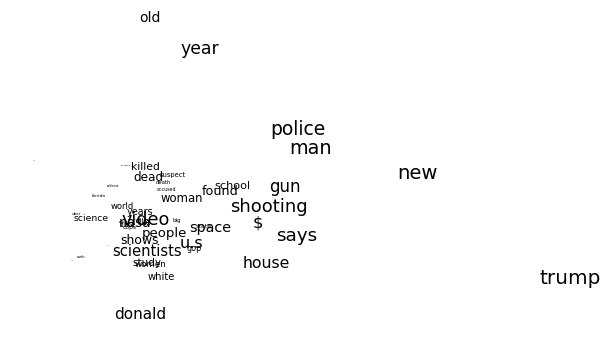

In [384]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

It is very weird to see that ``donald`` and ``trump`` are far way from each other. There is a pretty clear semantic cluster about CRIME, where ``police``, ``gun``, ``shooting``, ``school``, ``killed``, and ``dead`` are relatively close to each other. ``killed`` and ``dead`` are a little bit distant, indicating that the school shooting news in the corpus may not containing dead casualties.

Also, there is a small SCIENCE semantic cluster where ``scientists``, ``study``, ``space``, and ``shows`` are closely located.

In [354]:
# pca to reduce dimension
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

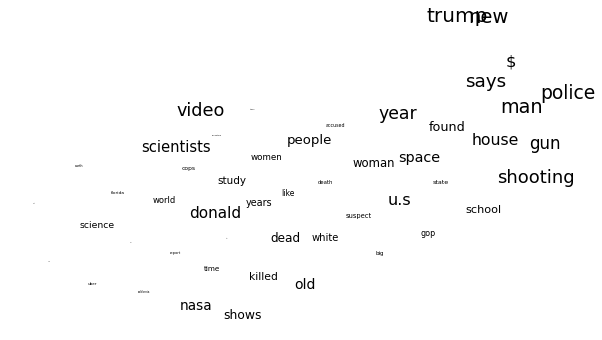

In [355]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Again, ``donald`` and ``trump`` are far way from each other. ``gun``, ``police``, ``shooting``, and ``school`` are still close to each other, indicating that there are school shooting news headlines in the courpus. However, ``killed`` and ``dead`` are more far away from the CRIME semantic cluster.

Moreover, the SCIENCE semantic cluster is broken apart.

In [369]:
numWords = 50
targetWords = dat_fourW2Vsg.wv.index2word[:numWords]

In [370]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(dat_fourW2Vsg[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.1397501 ,  0.13979718,  0.08016563, ..., -0.16412634,
         0.3910278 , -0.05154222],
       [-0.14565328,  0.17011185,  0.07065931, ..., -0.1624954 ,
         0.4025629 , -0.04489174],
       [-0.1833338 ,  0.17206584,  0.04619164, ..., -0.14334017,
         0.4199099 , -0.04254871],
       ...,
       [-0.18627053,  0.19252591,  0.04535959, ..., -0.16238557,
         0.41508853, -0.04517331],
       [-0.16366021,  0.15608655,  0.06793505, ..., -0.1609863 ,
         0.3936456 , -0.03653967],
       [-0.1771163 ,  0.17326616,  0.05137886, ..., -0.16131641,
         0.41692317, -0.04185735]], dtype=float32)

In [371]:
# pca to reduce dimension
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

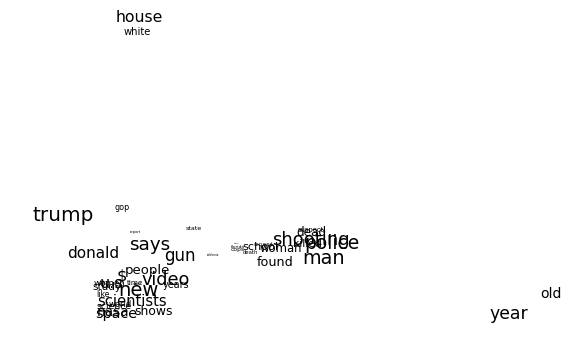

In [372]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

There are very clear semantic clusters. However, the semantics of these clusters are very vague. One nice thing is that ``trump`` and ``donald`` are very close to each other.

In [373]:
# pca to reduce dimension
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

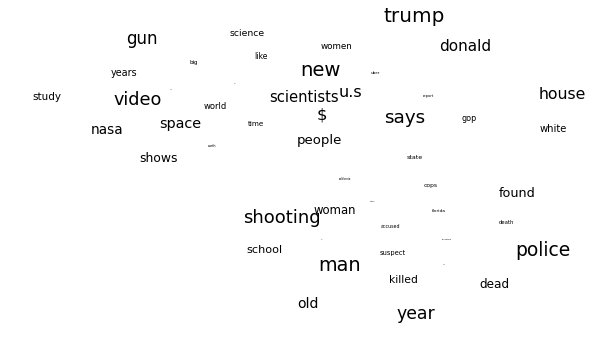

In [374]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

``donald`` and ``trump`` are again very close to each other. CRIME words are close, like ``police``, ``dead``, ``killed``, ``shooting`` and ``suspect``. Also, SCIENCE words like ``space``, ``nasa``, ``study``, and ``science`` are close. A POLITICS cluster is also pretty clear from the wordcloud: ``donald``, ``trump``, ``house``, ``white``, ``gop`` and ``u.s`` are close.

If considering about the similar words and analogies, the cbow model is better. It's results are closer to my expectation. On the other hand, the TSNE visualization shows that the skipgram does a good job in semantic clustering.

In [375]:
dat_fourW2V.save('dat_fourW2V')

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [47]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [48]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [49]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [50]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [51]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [52]:
apsD2V.docvecs[1952]

array([ 1.21300191e-01,  4.30804864e-02,  1.46425819e+00, -1.22975789e-01,
        9.24349070e-01,  4.97039735e-01,  1.33720005e+00,  8.45893919e-01,
       -1.11222517e+00, -6.62037611e-01,  8.41959000e-01, -6.38164639e-01,
       -5.78973413e-01,  1.00932527e+00,  1.17566562e+00,  1.12474525e+00,
        2.50399292e-01, -4.93687928e-01,  4.18236434e-01, -4.21031080e-02,
        1.12222396e-01,  2.98421741e-01, -2.26688117e-01, -9.73966643e-02,
       -5.31110704e-01, -1.15366077e+00,  9.35885385e-02,  8.42676401e-01,
        4.50239062e-01, -5.85226238e-01,  1.59627721e-01,  7.64533639e-01,
       -2.80932277e-01, -1.33928037e+00, -1.51986933e+00, -7.16083646e-01,
        4.46854204e-01,  7.91599929e-01, -2.46268734e-01,  3.48775297e-01,
       -1.99648589e-01,  1.13665950e+00, -1.33086070e-01,  1.91255724e+00,
        2.71067113e-01,  4.18982953e-02,  1.55444145e+00,  4.13530916e-01,
        8.10428798e-01,  2.36502871e-01, -1.96401715e+00,  1.26414323e+00,
       -8.85325313e-01, -

The words can still be accessed in the same way:

In [53]:
apsD2V['atom']

array([-0.09358301, -0.09536269,  0.01672625, -0.14331144,  0.35489732,
        0.2892696 , -0.02074733,  1.2688681 , -0.11122547, -0.6583179 ,
        0.3090718 , -0.6291851 ,  0.59231335,  0.21793418,  0.21050006,
        0.8164724 , -0.21774197,  0.24486496,  0.97751004, -0.5368866 ,
        0.09834187,  0.7803146 , -0.23946176, -0.53410256, -0.36009723,
       -0.57116246, -0.4156615 , -0.56836575,  0.19569126, -0.3041018 ,
       -0.23016286,  1.0786086 , -0.7519328 , -0.45523608, -1.0157202 ,
       -0.66696024,  0.04912785,  0.3948273 , -0.45929962,  0.26056555,
       -0.5623642 ,  0.29474658, -0.47118616, -0.15599078, -0.7661849 ,
        0.39904803,  0.580429  ,  0.6176453 ,  0.6954489 , -0.36065587,
       -0.27798125,  0.03840076, -0.92877793, -0.66550547,  0.23019077,
        0.50863487,  0.12302595,  1.6628438 ,  0.20671102,  0.56251025,
       -0.34487236, -1.3464847 , -0.08162022, -0.05922347,  0.34997225,
        0.44889918,  0.78675437,  0.07519421, -0.25470152,  0.78

We can still use the ``most_similar`` command to perform simple semantic equations:

In [54]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('farther', 0.7979008555412292)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [55]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('fluid', 0.9241598844528198)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [56]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.59510356]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [57]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.110.857', 0.5984702110290527),
 ('10.1103/PhysRev.95.67', 0.5965999364852905),
 ('10.1103/PhysRev.83.131', 0.5887880325317383),
 ('10.1103/PhysRev.105.139', 0.5757727026939392),
 ('10.1103/PhysRev.105.1469', 0.564139187335968)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

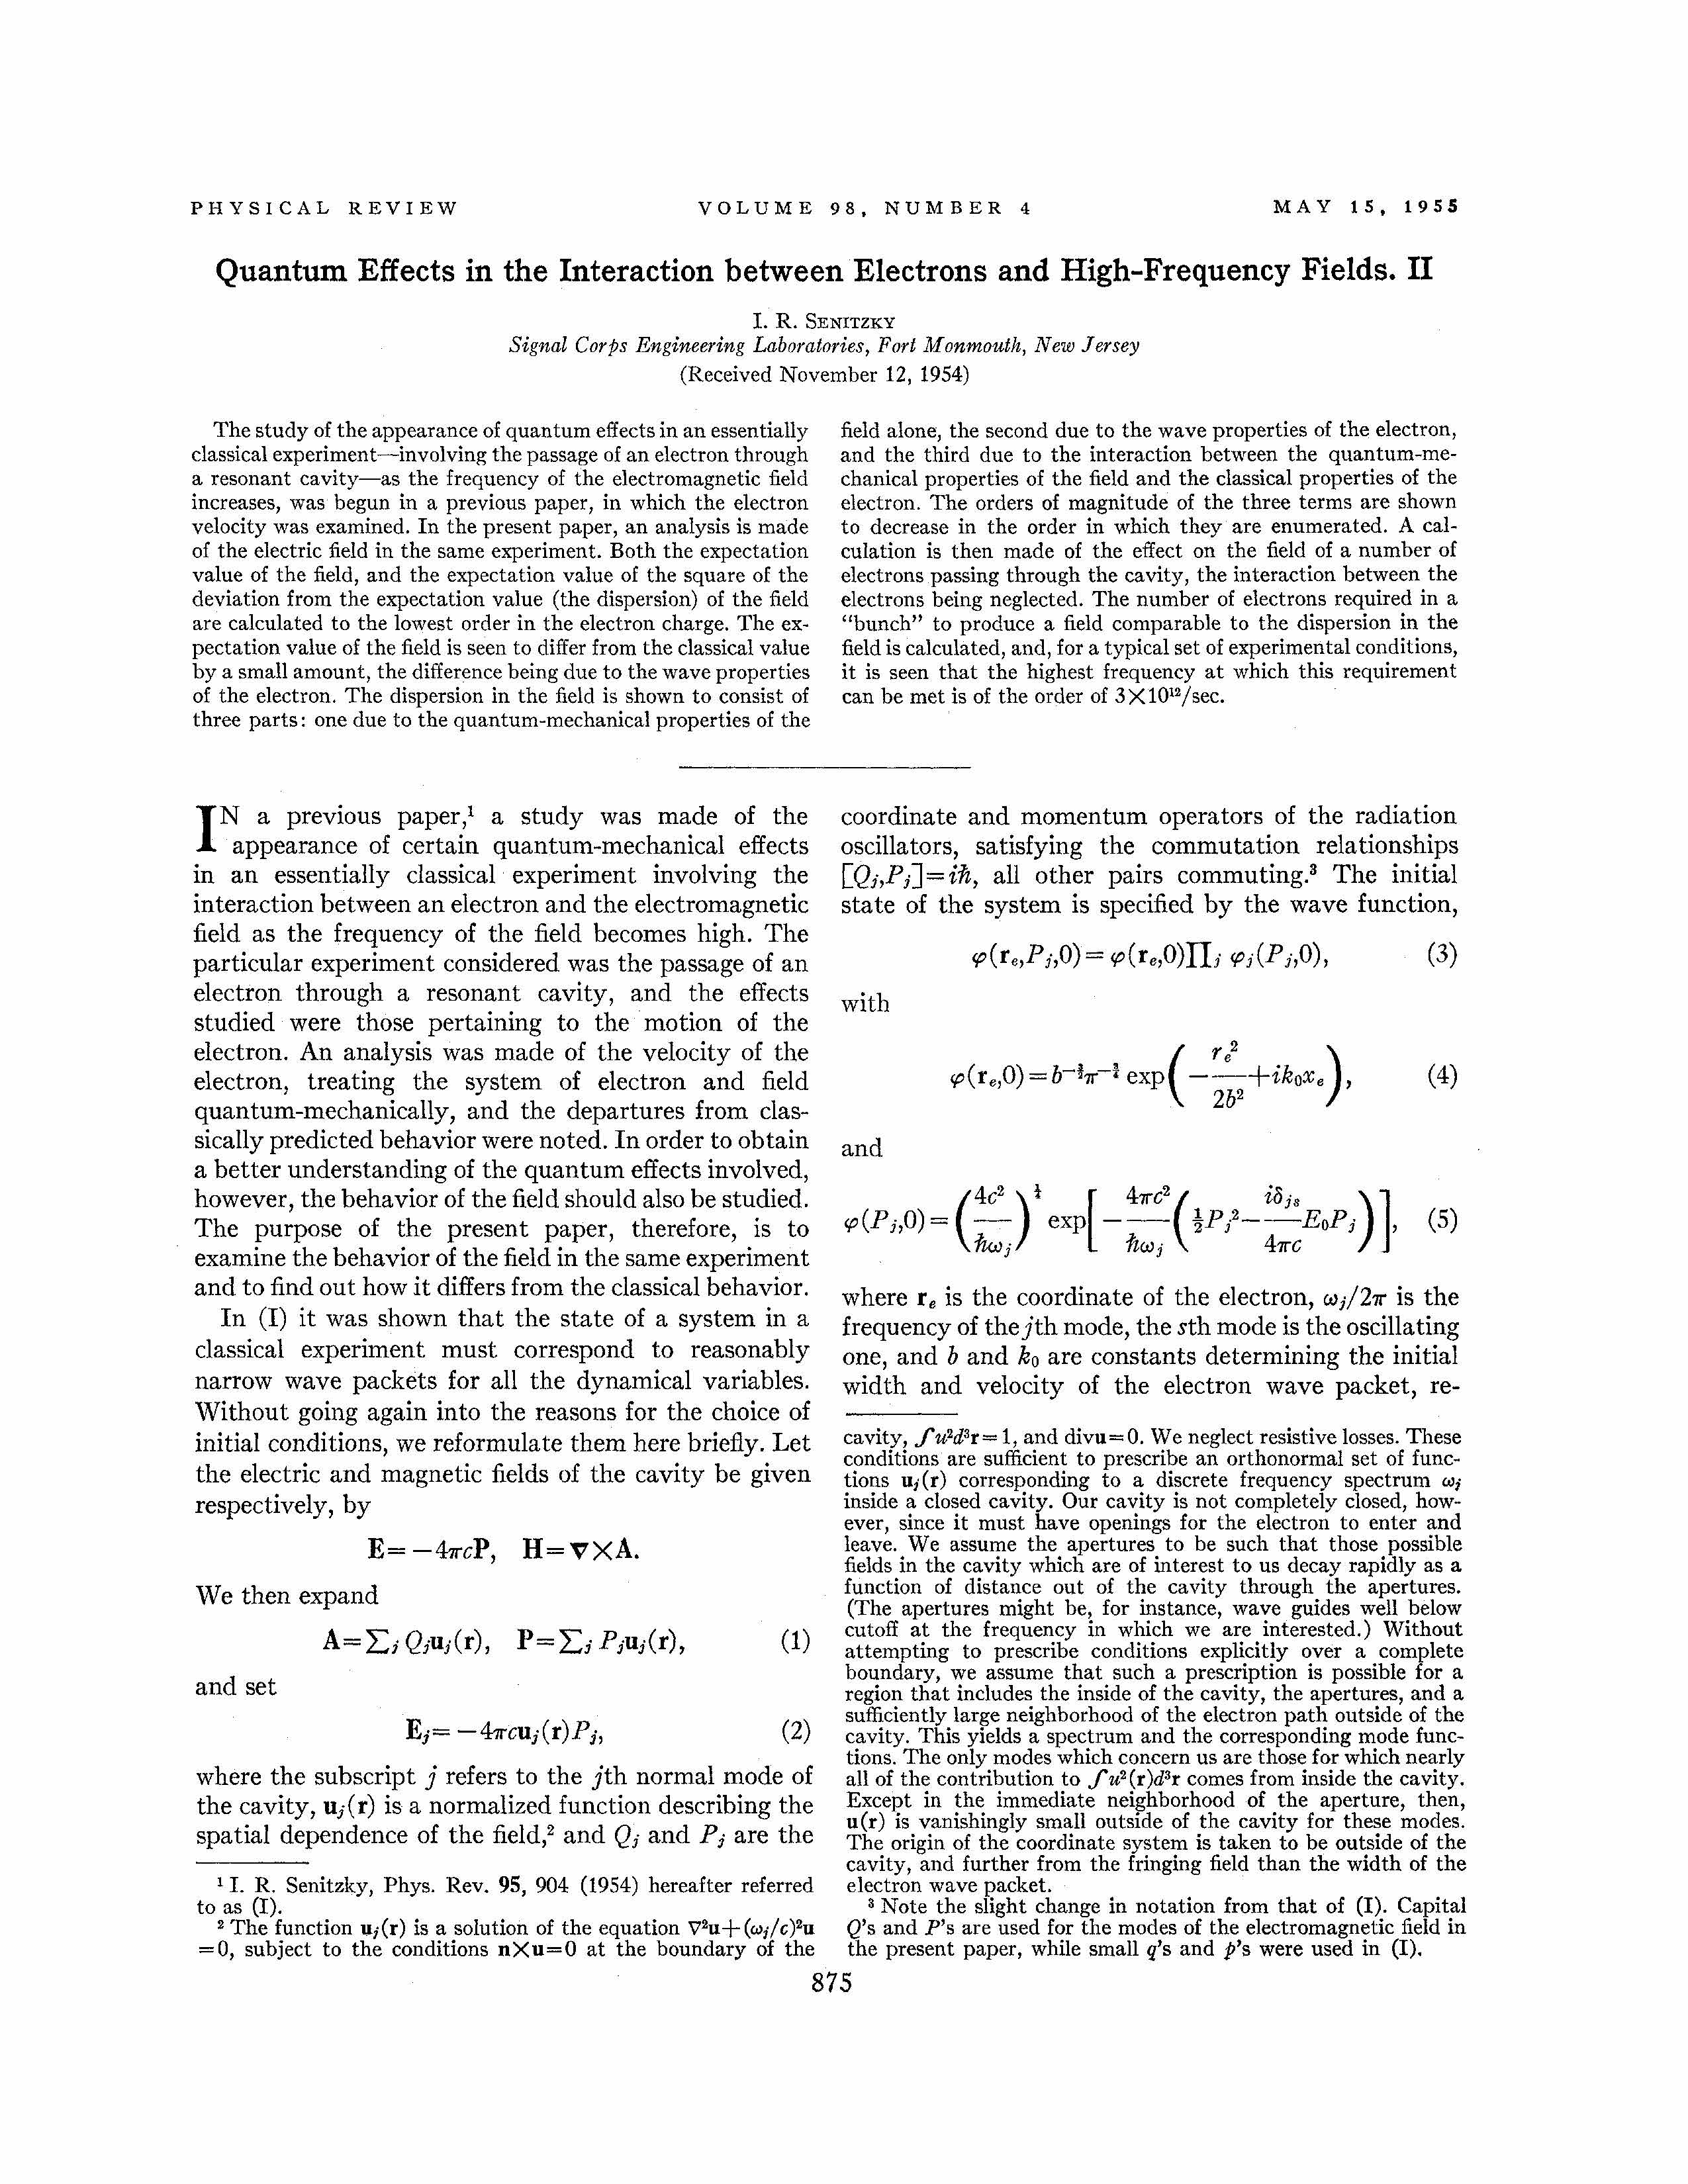

In [58]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [59]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('discontinuously', 0.8461110591888428),
 ('attained', 0.8277702927589417),
 ('emu', 0.8231347799301147),
 ('extrapolated', 0.8162022829055786),
 ('figure', 0.8116998672485352)]

We can even look for documents most like a query composed of multiple words:

In [60]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7727632522583008),
 ('10.1103/PhysRev.102.805', 0.7565857172012329),
 ('10.1103/PhysRev.100.145', 0.713464617729187),
 ('10.1103/PhysRev.108.570', 0.7096145153045654),
 ('10.1103/PhysRev.115.1277', 0.7093491554260254)]

Now let's plot some words and documents against one another with a heatmap:

In [61]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

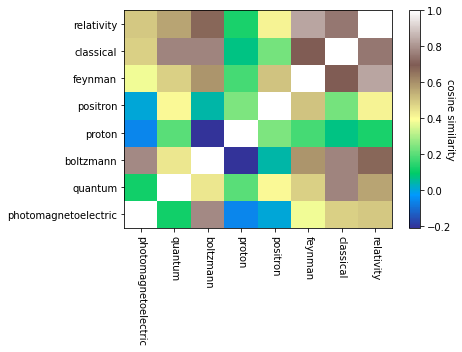

In [62]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [63]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

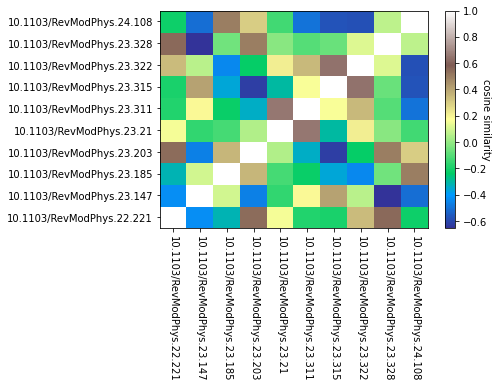

In [64]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [65]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

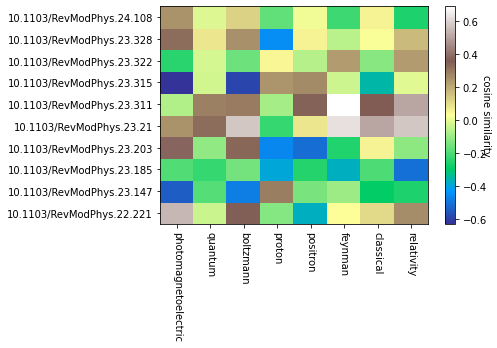

In [66]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [67]:
apsD2V.save('apsW2V')

We can later load it:

In [46]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [385]:
dat_four = get_category(dat, ['BUSINESS', 'POLITICS', 'CRIME', 'SCIENCE'], 2000)

In [386]:
dat_four.head()

,headline,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
13,Trump's Crackdown On Immigrant Parents Puts Mo...,POLITICS
14,'Trump's Son Should Be Concerned': FBI Obtaine...,POLITICS
15,Edward Snowden: There's No One Trump Loves Mor...,POLITICS
16,Booyah: Obama Photographer Hilariously Trolls ...,POLITICS


In [391]:
dat_four['tokenized_words'] = dat_four['headline'].apply(lambda x: lucem_illud.word_tokenize(x))
print('done tokenization')
dat_four['normalized_words'] = dat_four['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

done tokenization


In [392]:
keywords = ['science', 'killed', 'beat', 'beating', 'trump', 'shooting']

In [395]:
taggedDocs = []
for index, row in dat_four.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['category']) 
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
dat_four['TaggedHeadline'] = taggedDocs

dat_four[:10]

,headline,category,tokenized_sents,normalized_sents,tokenized_words,normalized_words,TaggedHeadline
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME,"[[There, Were, 2, Mass, Shootings, In, Texas, ...","[[mass, shootings, texas, week, tv]]","[There, Were, 2, Mass, Shootings, In, Texas, L...","[mass, shootings, texas, week, tv]","([mass, shootings, texas, week, tv], [CRIME])"
13,Trump's Crackdown On Immigrant Parents Puts Mo...,POLITICS,"[[Trump, 's, Crackdown, On, Immigrant, Parents...","[[trump, crackdown, immigrant, parents, puts, ...","[Trump, 's, Crackdown, On, Immigrant, Parents,...","[trump, crackdown, immigrant, parents, puts, k...","([trump, crackdown, immigrant, parents, puts, ..."
14,'Trump's Son Should Be Concerned': FBI Obtaine...,POLITICS,"[[Trump, 's, Son, Should, Be, Concerned, FBI, ...","[[trump, son, concerned, fbi, obtained, wireta...","[Trump, 's, Son, Should, Be, Concerned, FBI, O...","[trump, son, concerned, fbi, obtained, wiretap...","([trump, son, concerned, fbi, obtained, wireta..."
15,Edward Snowden: There's No One Trump Loves Mor...,POLITICS,"[[Edward, Snowden, There, 's, No, One, Trump, ...","[[edward, snowden, trump, loves, vladimir, put...","[Edward, Snowden, There, 's, No, One, Trump, L...","[edward, snowden, trump, loves, vladimir, putin]","([edward, snowden, trump, loves, vladimir, put..."
16,Booyah: Obama Photographer Hilariously Trolls ...,POLITICS,"[[Booyah, Obama, Photographer, Hilariously, Tr...","[[booyah, obama, photographer, hilariously, tr...","[Booyah, Obama, Photographer, Hilariously, Tro...","[booyah, obama, photographer, hilariously, tro...","([booyah, obama, photographer, hilariously, tr..."
17,Ireland Votes To Repeal Abortion Amendment In ...,POLITICS,"[[Ireland, Votes, To, Repeal, Abortion, Amendm...","[[ireland, votes, repeal, abortion, amendment,...","[Ireland, Votes, To, Repeal, Abortion, Amendme...","[ireland, votes, repeal, abortion, amendment, ...","([ireland, votes, repeal, abortion, amendment,..."
18,Ryan Zinke Looks To Reel Back Some Critics Wit...,POLITICS,"[[Ryan, Zinke, Looks, To, Reel, Back, Some, Cr...","[[ryan, zinke, looks, reel, critics, grand, pi...","[Ryan, Zinke, Looks, To, Reel, Back, Some, Cri...","[ryan, zinke, looks, reel, critics, grand, piv...","([ryan, zinke, looks, reel, critics, grand, pi..."
19,Trump's Scottish Golf Resort Pays Women Signif...,POLITICS,"[[Trump, 's, Scottish, Golf, Resort, Pays, Wom...","[[trump, scottish, golf, resort, pays, women, ...","[Trump, 's, Scottish, Golf, Resort, Pays, Wome...","[trump, scottish, golf, resort, pays, women, s...","([trump, scottish, golf, resort, pays, women, ..."
30,"Jack Johnson Was Pardoned, But Taboo Sex Is St...",POLITICS,"[[Jack, Johnson, Was, Pardoned, But, Taboo, Se...","[[jack, johnson, pardoned, taboo, sex, crimina...","[Jack, Johnson, Was, Pardoned, But, Taboo, Sex...","[jack, johnson, pardoned, taboo, sex, criminal...","([jack, johnson, pardoned, taboo, sex, crimina..."
32,Rachel Dolezal Faces Felony Charges For Welfar...,CRIME,"[[Rachel, Dolezal, Faces, Felony, Charges, For...","[[rachel, dolezal, faces, felony, charges, wel...","[Rachel, Dolezal, Faces, Felony, Charges, For,...","[rachel, dolezal, faces, felony, charges, welf...","([rachel, dolezal, faces, felony, charges, wel..."


In [396]:
dat_fourD2V = gensim.models.doc2vec.Doc2Vec(dat_four['TaggedHeadline'], size = 100)

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [412]:
dat_fourD2V.most_similar(positive = ['trump','shoot'], topn = 1)

[('murder', 0.9962721467018127)]

In [413]:
dat_fourD2V.most_similar(positive = ['trump','shooting'], topn = 1)

[('fbi', 0.9986890554428101)]

The result here are more expected than the one from the word2vec model. In the word2vec model, I got ``change``, but here I got some CRIME related words like ``murder`` and ``fbi``. 

In [416]:
dat_fourD2V.most_similar(['beat'], topn = 10)

[('calls', 0.9957753419876099),
 ('child', 0.995599627494812),
 ('jared', 0.9954847097396851),
 ('security', 0.9952651858329773),
 ('force', 0.9952569007873535),
 ('reports', 0.994848906993866),
 ('trying', 0.9947424530982971),
 ('fire', 0.9946885108947754),
 ('national', 0.994483470916748),
 ('mike', 0.9943649172782898)]

In [417]:
dat_fourD2V.most_similar(['beating'], topn = 10)

[('police', 0.9977033138275146),
 ('man', 0.9974284172058105),
 ('allegedly', 0.996772825717926),
 ('arrested', 0.9965946674346924),
 ('charged', 0.9965913891792297),
 ('young', 0.9965276718139648),
 ('leaves', 0.9964708089828491),
 ('texas', 0.9963517189025879),
 ('dies', 0.9962702989578247),
 ('alleged', 0.9962579011917114)]

Different from Word2vec, both ``beating`` and ``beat`` here are close to CRIME related words.

In [397]:
dat_fourD2V.most_similar(positive = ['science','good'], negative = ['important'], topn = 1)

[('like', 0.9903723001480103)]

It seems like that science that are good but not important are popular in the headlines in this corpus.

In [418]:
dat_fourD2V.docvecs.most_similar([dat_fourD2V['trump']], topn=10)

[('beat', 0.9928668141365051),
 ('POLITICS', 0.9653093814849854),
 ('BUSINESS', 0.877921998500824),
 ('science', 0.8770774006843567),
 ('beating', 0.8701760768890381),
 ('SCIENCE', 0.8163615465164185),
 ('CRIME', 0.804049015045166),
 ('shooting', 0.7753297090530396),
 ('killed', 0.7532349228858948),
 ('trump', 0.7023139595985413)]

As the categories are not unique in this corpus, let's only look at the categories in this rank. POLITICS first, then BUSINESS, then SCIENCE, and CRIME the last, which accords with my expectation.

In [419]:
dat_fourD2V.docvecs.most_similar([dat_fourD2V['beat']], topn=10)

[('beat', 0.993218719959259),
 ('POLITICS', 0.9430369734764099),
 ('beating', 0.8971813917160034),
 ('science', 0.8752524256706238),
 ('BUSINESS', 0.8513968586921692),
 ('CRIME', 0.8371596336364746),
 ('SCIENCE', 0.8266596794128418),
 ('shooting', 0.8069057464599609),
 ('killed', 0.7903640270233154),
 ('trump', 0.6492208242416382)]

In [420]:
dat_fourD2V.docvecs.most_similar([dat_fourD2V['beating']], topn=10)

[('beating', 0.9963875412940979),
 ('CRIME', 0.9810720682144165),
 ('killed', 0.9610021710395813),
 ('shooting', 0.9564241170883179),
 ('beat', 0.9214719533920288),
 ('POLITICS', 0.7783360481262207),
 ('BUSINESS', 0.6964572668075562),
 ('science', 0.6905349493026733),
 ('SCIENCE', 0.6722345352172852),
 ('trump', 0.3448558449745178)]

The ranking of the categories shows that my assumption in exercise 1 was right: ``beat`` is more used as a noun as in BUSINESS and in POLITICS. One the other hand, ``beating`` is more used as a gerund of the verb, which is closed to CRIME.

In [421]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = dat_fourD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dat_fourD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

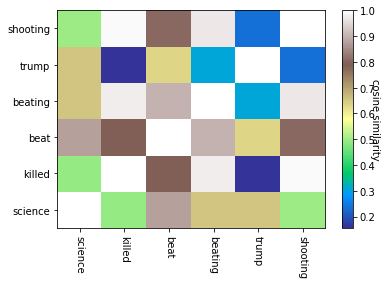

In [422]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

The CRIME words like ``shooting``, ``beating``, and ``killed`` are very close.  

It is interesting to see that ``beat`` and ``beating`` do not have the highest similarity (not white), which again supports my assumption in exercise 1.``beat`` is also close to ``science`` and other CRIME words.

``trump`` is close to SCIENCE word science and POLITICS and BUSINESS word ``beat`` as expected.

In [448]:
targetDocs = {'POLITICS':'POLITICS', 'BUSINESS':'BUSINESS', 'SCIENCE':'SCIENCE', 'CRIME':'CRIME'}
heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = dat_fourD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dat_fourD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

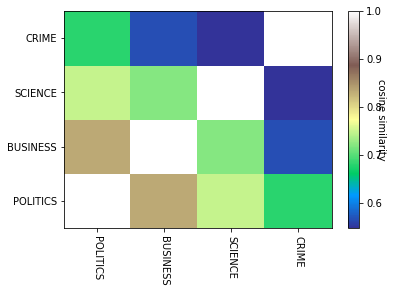

In [449]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

CRIME is only close to POLITICS, and POLITICS, BUSINESS and SCIENCE are relatively close to each other. This indicates that POLITICS, BUSINESS, and SCIENCE form a semantic cluster in this corpus.

In [450]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = dat_fourD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dat_fourD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

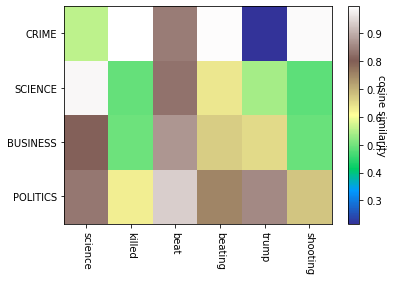

In [451]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

``beat`` is closer to BUSINESS and POLITICS than to SCIENCE as expected, and CRIME words ``beating``, ``shooting``, and ``killed`` are close to CRIME. ``science`` is close to POLITICS and BUSINESS, and ``trump`` is close to POLITICS and BUSINESS. All of these observations are aligned with previous observations in this model.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [68]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [69]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [70]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

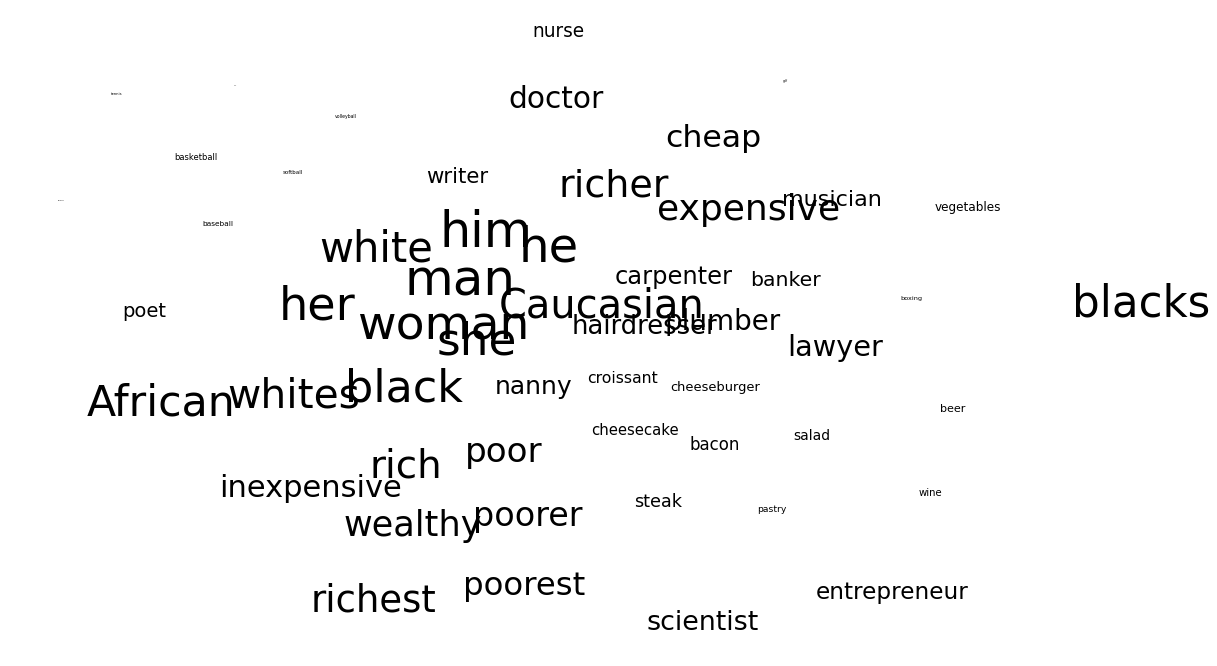

In [71]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [72]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [73]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [74]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [75]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [76]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [77]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

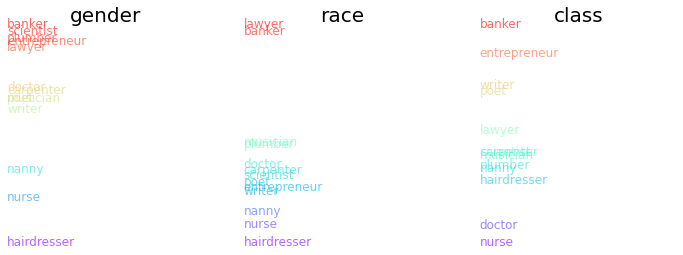

In [78]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

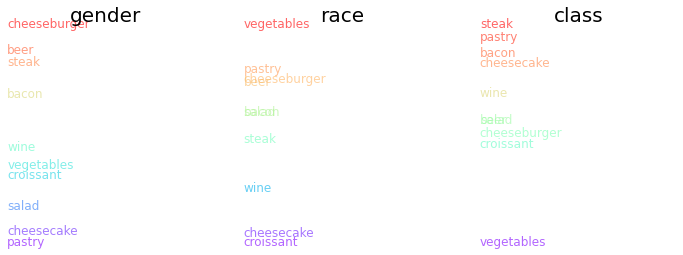

In [79]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

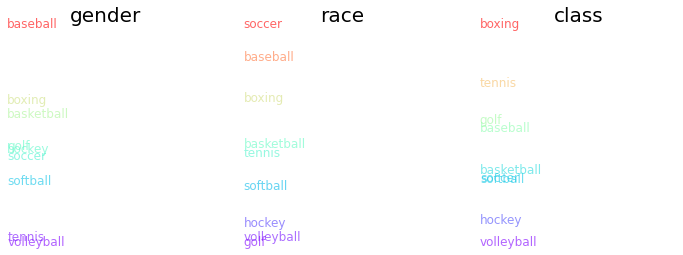

In [80]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [467]:
# words to create dimensions
dfTargetWords = ['good', 'bad', 'democratic', 'republican', 'poor', 'rich']
# words we will be mapping
dfTargetWords += ['science', 'gun', 'trump', 'policy', 'dead', 'police', 'men', 'women', 'space', 'criminal', 'school', 'business', 'student']

In [468]:
wordsSubMatrix = []
for word in dfTargetWords:
    wordsSubMatrix.append(dat_fourW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.11060883,  0.13915467,  0.04815425, ..., -0.11034693,
         0.25935298, -0.01617414],
       [-0.06274448,  0.0739779 ,  0.02102411, ..., -0.0604008 ,
         0.14666651, -0.00707701],
       [-0.08213798,  0.10662984,  0.03273419, ..., -0.08506697,
         0.18697172, -0.00975777],
       ...,
       [-0.2649139 ,  0.33374035,  0.10607375, ..., -0.26720878,
         0.61474556, -0.03163733],
       [-0.15214777,  0.19763751,  0.06570891, ..., -0.1575624 ,
         0.36571687, -0.02270212],
       [-0.13844416,  0.17447971,  0.05828016, ..., -0.14442785,
         0.33068702, -0.0140154 ]], dtype=float32)

In [469]:
pcaWordsdf = sklearn.decomposition.PCA(n_components = 10).fit(wordsSubMatrix)
reducedPCA_datadf = pcaWordsdf.transform(wordsSubMatrix)
tsneWordsdf = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_datadf)

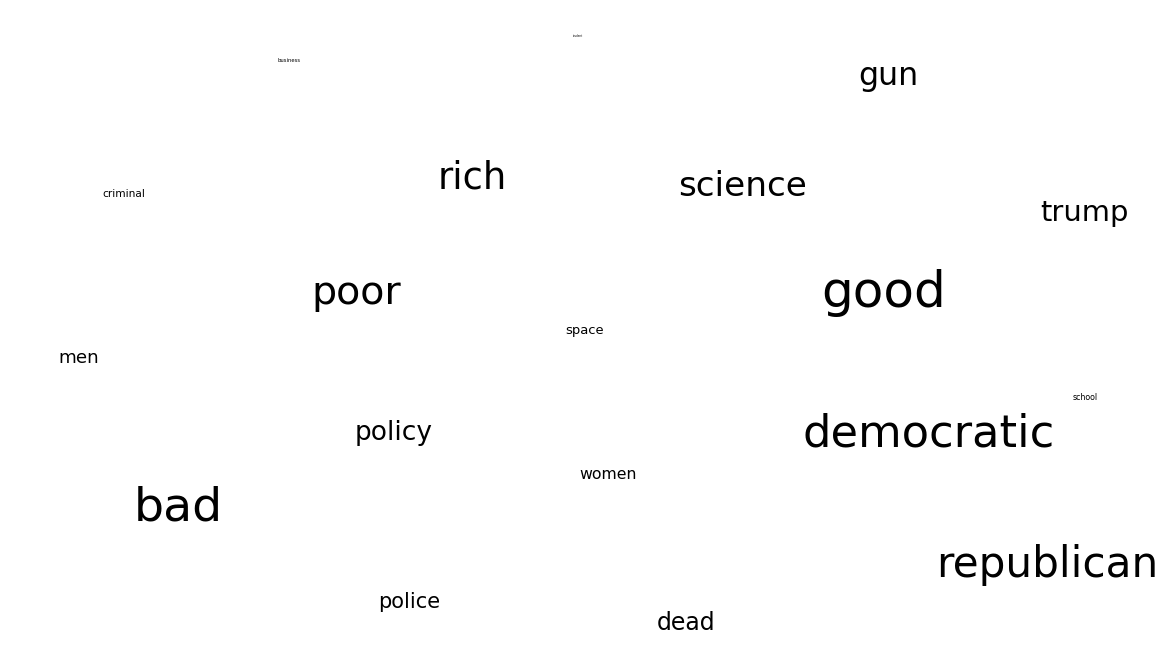

In [470]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsdf[:, 0], tsneWordsdf[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(dfTargetWords):
    ax.annotate(word, (tsneWordsdf[:, 0][i],tsneWordsdf[:, 1][i]), size =  50 * (len(dfTargetWords) - i) / len(dfTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [472]:
left_or_right = dimension(dat_fourW2V.wv, ['democratic'], ['republican'])

In [473]:
word_list = ['science', 'gun', 'trump', 'policy', 'dead', 'police', 'men', 'women', 'space', 'criminal', 'school', 'business', 'student']

In [491]:
def makeDF(model, word_list):
    d_i = []
    for word in word_list:
        d_i.append(sklearn.metrics.pairwise.cosine_similarity(dat_fourW2V.wv[word].reshape(1,-1), left_or_right.reshape(1,-1))[0][0])
    df = pd.DataFrame({'left_or_right': d_i}, index = word_list)
    return df

In [492]:
plot1df = makeDF(dat_fourW2V.wv, word_list)

In [497]:
rich_or_poor = dimension(dat_fourW2V.wv, ['rich'], ['poor'])

In [498]:
def makeDF(model, word_list):
    d_i = []
    for word in word_list:
        d_i.append(sklearn.metrics.pairwise.cosine_similarity(dat_fourW2V.wv[word].reshape(1,-1), rich_or_poor.reshape(1,-1))[0][0])
    df = pd.DataFrame({'rich_or_poor': d_i}, index = word_list)
    return df

In [499]:
plot2df = makeDF(dat_fourW2V.wv, word_list)

In [487]:
good_or_bad = dimension(dat_fourW2V.wv, ['good'], ['bad'])

In [495]:
def makeDF(model, word_list):
    d_i = []
    for word in word_list:
        d_i.append(sklearn.metrics.pairwise.cosine_similarity(dat_fourW2V.wv[word].reshape(1,-1), good_or_bad.reshape(1,-1))[0][0])
    df = pd.DataFrame({'good_or_bad': d_i}, index = word_list)
    return df

In [496]:
plot3df = makeDF(dat_fourW2V.wv, word_list)

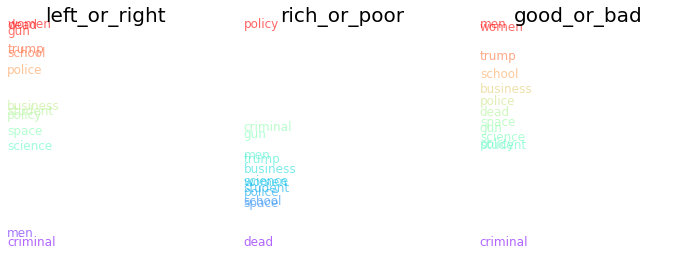

In [507]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, plot1df, 'left_or_right')

ax1 = fig.add_subplot(132)
PlotDimension(ax1, plot2df, 'rich_or_poor')

ax1 = fig.add_subplot(133)
PlotDimension(ax1, plot3df, 'good_or_bad')

Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why?

For the ``left_or_right`` dimension, ``trump`` is closer to ``left``, and Donald Trump has been believed to be 'Trumpist', which is neither left nor right. Interestingly, ``criminial`` is closer to ``right``, but other CRIME words like ``police``, ``gun`` and ``dead`` are closer to ``left``. SCIENCE words are in the middle.

For the ``rich_or_poor`` dimension, ``policy`` is the closest to rich to ``rich``, indicating the policy mentioned in the news are more about ``rich``. Interestingly, ``crinimal`` and ``gun`` are in the middle, probabily because news about CRIME are usually involving both ``rich`` and ``poor``. All other words are closer to ``poor``, including SCIENCE words, ``trump``, ``business``, and ``dead``. ``dead`` is the closest to ``poor``, indicating that ``poor`` and ``dead`` are closet in the news in the corpus.

For the ``good_or_bad`` dimension, only ``criminal`` is very close to ``bad``. Most of the CRIME words are in the middle. Neural words like ``men`` and ``women`` are closet to good, probabily because ``good`` are usually used as a adj. for noun phrases of ``men`` and ``women``. ``trump`` and ``school`` are also close to ``good``.

``left_or_right`` explain the most variation in the projection of my words. The words are most spread out in this dimension. Also, more than 3/4 of the words in the words list are from POLITICS, BUSINESS, and CRIME. In all of these categories, ``left_or_right`` can be very meaningful.

In [594]:
avg = plot1df
avg['rich_or_poor'] = plot2df['rich_or_poor']
avg['good_or_bad'] = plot3df['good_or_bad']

In [597]:
avg['avg']= avg.mean(axis = 1)

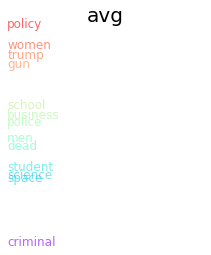

In [599]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(132)
PlotDimension(ax1, avg, 'avg')

There are still some words remained unchanged, like ``policy`` and ``criminal``. However, ``gun`` is very postive because it has a large weight in ``left_or_right``. ``space`` and ``science`` are more negative in this dimension. In general, I think this combined dimension is more difficult to interpret. Even though the words are more spread out in this dimension, I think this is not as good as the single pair dimensions.

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [82]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


We can examine the vacabularies of this model by building a word-index map:

In [83]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [84]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
...,...,...,...,...,...,...,...,...,...,...
95,157791,Golden Living,"Here at Golden LivingCenters, we rely on and t...",Nebraska,40.67667,-95.85917,High school diploma or equivalent;Must within ...,NaN,"[[Here, at, Golden, LivingCenters, ,, we, rely...","[[here, at, golden, livingcenters, we, rely, o..."
96,119835,GameStop,"""*Description* Description: SUMMARY At GameSto...",New York,40.68149,-73.39984,NaN,NaN,"[[``, *Description*, Description, :, SUMMARY, ...","[[description, summary, at, gamestop, we, refe..."
97,285609,Jewel-Osco,"""Updated 6/2011 JOB TITLE: Service Clerk (Bagg...",Illinois,41.66892,-87.73866,NaN,"Provides prompt, efficient and friendly custom...","[[``, Updated, 6/2011, JOB, TITLE, :, Service,...","[[updated, job, title, service, clerk, bagger,..."
98,89260,Express Scripts,"""Schedule: Full-time Job ID: 1500071I The Sale...",Missouri,38.62727,-90.19789,NaN,o Proactive management of Houston entry & comp...,"[[``, Schedule, :, Full-time, Job, ID, :, 1500...","[[schedule, job, id, the, sales, coordinator, ..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [88]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [89]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [90]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [91]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [92]:
adprob([["python", "programming"]], resume_model)

-14.131331

In [93]:
adprob([["julia", "programming"]], resume_model)

-33.00093

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [94]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-26.204546
Legrand North America,-39.793274
Franciscan St. Eilzabeth Health,-42.391022
Illinois Wesleyan University,-51.639965
Gold's Gym,-73.763107
...,...
G6 Hospitality,-459.108154
Epic Health Services,-517.406250
Kforce,-747.180603


We can also look at the mean likelihood of each state.

In [95]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-39.793274
Montana,-62.516636
Connecticut,-66.327652
Kansas,-83.626266
Tennessee,-91.485634
Illinois,-92.264763
New Hampshire,-92.409035
Georgia,-100.317818
South Carolina,-101.541153


You would increase the sample size if you want to do a more serious study.

## <font color="red">*Exercise 4a*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

I chose to use the Twitter Sentiment Analysis dataset from kaggle. (https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=train.csv)

In [541]:
dat_fourW2V = gensim.models.word2vec.Word2Vec(dat_four['normalized_sents'].sum(), sg = 0, hs = 1, negative = 0)

In [509]:
sampleDF = pd.read_csv('twitter.csv')

In [517]:
sampleDF = sampleDF.sample(100)

In [519]:
sampleDF['tokenized_sents'] = sampleDF['tweet'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
sampleDF['normalized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [528]:
def tweetprob(tweet, model):
    sen_scores = model.score(tweet, len(tweet))
    tweet_score = sen_scores.mean()
    return tweet_score

In [542]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: tweetprob(x, dat_fourW2V))

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\word2vec.py:945: UserWarning: C extension compilation failed, scoring will be slow. Install a C compiler and reinstall gensim for fastness.
  warnings.warn(


In [554]:
for twt in sampleDF.sort_values(by = 'likelihood', ascending = False)['tweet'][:5]:
    print (twt + '\n\n')

very   and no one is #makingsense 


  bihday your majesty


this a a fantastic rub for steak #yum #thespicesndteaexchange #dc   #healthyâ¦ 


@user your comment = â¬ 5,- donation for #tefugeeswelcome â¤  sucks


its #humpday! you're nearly over it!   wednesday 




The 5 tweets that have the highest likelihood are kind of meaningless in terms of the topics in the ``dat_four`` dataset.

In [545]:
for twt in sampleDF.sort_values(by = 'likelihood', ascending = True)['tweet'][:5]:
    print (twt + '\n\n')

clueless top nyc cop william bratton promises 2 lead the nation in small #marijuana arrests   â&gt; 


my baby came back home today â¤ï¸ðð¼ðð¼ we missed each other like crazy &amp; he was only gone for 3 days ð­ð­  #attachedatthehip


father's day at #kirkstallabbey for @user i've never seen a #dad so   with fake ears and leaves before! 


it's one of those days again.. monday..missing mom a lot..ð¢ramadan..can't have coffee.. missing tammy heaps..can't see her face live. ð  


frwd to all frinds #best poetry #romantic poetry #love poetry #new poetry   poetry free hasil karain + follow @user send to 4...




The first tweet is actually more meaningful than the top 5. For example, there is ``nyc`` and ``pop``, which can be related to the news. One possibility is that news headlines tend to use more formal words like ``New York City`` and ``police``.

As such, I think the boundary of my model is that it tends to have more formal words, which can miss the meanings of many informal words that could be closely related to the contents of the dataset.

In [556]:
sampleDF.groupby('label')[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
label,
1,-11.725638
0,-17.007605


In this dataset, ``label``== 1 means that the tweet is racist/sexit, and ``label``== 0 means that the tweet is not racist/sexist.

It appears that the racist tweets are more likely to be generated from the news category dataset. It is probabily caused by the topic contained in the news dataset (CRIME). CRIME can be caused by racism, but the observation above shows that the high likelihood tweets seem to have nothing to do with CRIME.

In [557]:
tweetprob([["change", "policy"]], dat_fourW2V)

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\word2vec.py:945: UserWarning: C extension compilation failed, scoring will be slow. Install a C compiler and reinstall gensim for fastness.
  warnings.warn(


-14.739262

In [558]:
tweetprob([["change", "trump"]], dat_fourW2V)

-10.736457

In [563]:
tweetprob([["change", "democrat"]], dat_fourW2V)

-13.321721

In [560]:
tweetprob([["change", "biden"]], dat_fourW2V)

-15.494854

In [559]:
tweetprob([["change", "republican"]], dat_fourW2V)

-14.492171

It is interesting to see ``democrat`` and ``trump`` are more likely to be in the news, indicating that ``democrat`` and ``trump`` more like to advertise their idea of ``change`` comparing to ``republican`` and ``biden`` (in the news captured by this dataset).

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [96]:
import copy

In [97]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [98]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [99]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [100]:
ascoDF

,Year,AbstractCategory,Title,FirstAuthor,Body,AbstractPublicationID,tokenized_sents,normalized_sents
0,1995,Lung Cancer,Treatment of non-small cell lung cancer with c...,GP Stathopoulos,Cisplatin compound is established as the main ...,1181,"[[Cisplatin, compound, is, established, as, th...","[[cisplatin, compound, established, main, drug..."
1,1995,Breast Cancer,Treatment of primary breast cancer without mas...,A Bluming,"Between March 24, 1977, and March 24, 1983, 15...",270,"[[Between, March, 24, 1977, and, March, 24, 19...","[[march, march, women, primary, breast, cancer..."
2,1995,Gynecologic Cancer,Treatment of relapsed ovarian carcinoma with e...,M Metzner,ECF has established activity and a high respon...,784,"[[ECF, has, established, activity, and, a, hig...","[[ecf, established, activity, high, response, ..."
3,1995,Lung Cancer,Treatment of small cell lung cancer (SCLC) wit...,JD Hainsworth,"In 7/93, we began investigation of a three-dru...",1197,"[[In, 7/93, we, began, investigation, of, a, t...","[[began, investigation, drug, combination, pac..."
4,1995,Other Gastrointestinal Cancer,Vaccine-based (active specific) chemoimmunothe...,SH Itzkowitz,Active specific immunotherapy (ASI) is the adm...,549,"[[Active, specific, immunotherapy, ASI, is, th...","[[active, specific, immunotherapy, asi, admini..."
...,...,...,...,...,...,...,...,...
62568,2011,Lung Cancer - Local-Regional and Adjuvant Ther...,Management of thymic epithelial tumors (TETs) ...,A. Rajan,<p><b>Background: </b> TETs are very rare ante...,NaN,"[[<, p><b, >, Background, <, /b, >, TETs, are,...","[[<, p><b, >, background, <, /b, >, tets, rare..."
62576,2011,Patient and Survivor Care,Spinal or epidural analgesia for cancer pain: ...,N. Yarom,<p><b>Background:</b> Cancer pain is occasiona...,NaN,"[[<, p><b, >, Background:</b, >, Cancer, pain,...","[[<, p><b, >, background:</b, >, cancer, pain,..."
62577,2011,Developmental TherapeuticsÑExperimental Therap...,Comparative PARP enzyme inhibition of PF-01367...,K. A. Kern,<p><b>Background:</b> Within the past several ...,NaN,"[[<, p><b, >, Background:</b, >, Within, the, ...","[[<, p><b, >, background:</b, >, past, years, ..."
62585,2011,Genitourinary Cancer,Risk stratification and stage migration effect...,B. B. Desai,<p><b>Background:</b> To evaluate the diagnost...,NaN,"[[<, p><b, >, Background:</b, >, To, evaluate,...","[[<, p><b, >, background:</b, >, evaluate, dia..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [101]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [102]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [103]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [104]:
rawEmbeddings.keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [105]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


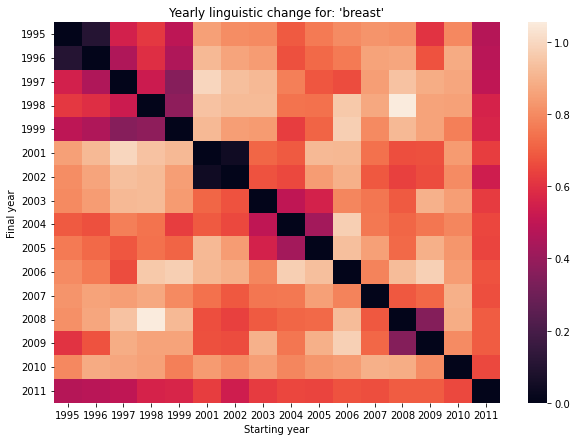

In [106]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

combination


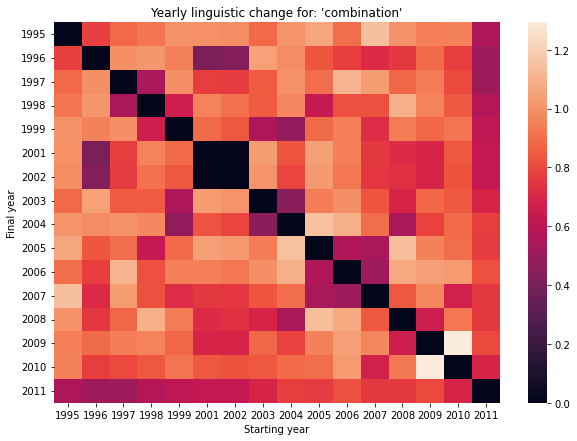

In [107]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [108]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [109]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1791 words to compare


The most divergent words are:

In [110]:
wordDivergences[:20]

[('paclitaxel', 14.392312013544142),
 ('combination', 14.047113169683143),
 ('fu', 14.027974743396044),
 ('g', 13.910592599073425),
 ('regimen', 13.710875991964713),
 ('cisplatin', 13.537563688121736),
 ('schedule', 13.532209186814725),
 ('infusion', 13.46731063281186),
 ('doses', 13.41245672153309),
 ('tolerated', 13.296279426664114),
 ('t', 13.292573051992804),
 ('administered', 13.273687518201768),
 ('csf', 13.250760787166655),
 ('plus', 13.215835768729448),
 ('carboplatin', 13.172698539681733),
 ('c', 13.09719095658511),
 ('weekly', 13.034352316521108),
 ('trial', 12.960106495767832),
 ('phase', 12.919021340552717),
 ('given', 12.826380608894397)]

And the least:

In [111]:
wordDivergences[-20:]

[('existing', 1.2739784717559814),
 ('exists', 1.269607663154602),
 ('particular', 1.2242765426635742),
 ('efficiency', 1.2228829860687256),
 ('nature', 1.222705602645874),
 ('agreement', 1.2191400527954102),
 ('preferences', 1.2105379104614258),
 ('account', 1.1838575601577759),
 ('require', 1.1654652953147888),
 ('condition', 1.1581761837005615),
 ('widespread', 1.1261398196220398),
 ('practical', 1.1109711527824402),
 ('bias', 1.0971805453300476),
 ('ensure', 1.03878915309906),
 ('forms', 1.0299965143203735),
 ('special', 1.0172021985054016),
 ('consider', 0.9958616495132446),
 ('uncertain', 0.9911394119262695),
 ('definition', 0.9743845462799072),
 ('simple', 0.9685645699501038)]

paclitaxel


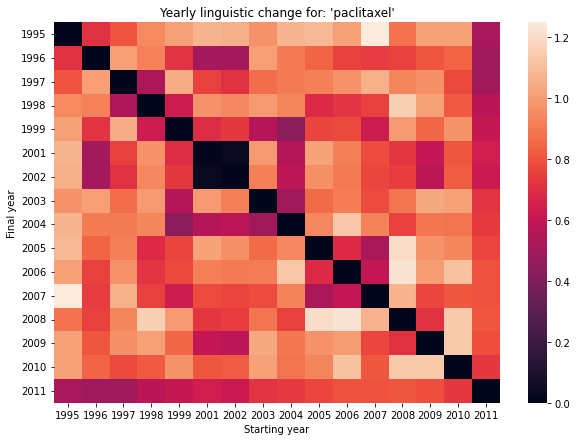

In [112]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

simple


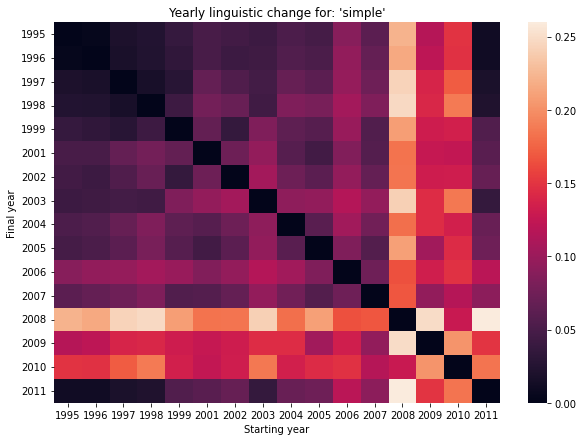

In [113]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [116]:
corpora_address = "../data/COHA"

In [117]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1810s_kso.zip
text_1820s_jsi.zip
text_1830s_bsu.zip
text_1840s_nsq.zip
text_1850s_jpr.zip
text_1860s_psi.zip
text_1870s_vuy.zip
text_1880s_azz.zip
text_1890s_jsq.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1930s_bie.zip
text_1940s_bsw.zip
text_1950s_ndz.zip
text_1960s_xus.zip
text_1970s_jfy.zip
text_1980s_bkk.zip
text_1990s_bsj.zip
text_2000s_scc.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [118]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [120]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue

C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


KeyboardInterrupt: 

We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <font color="red">*Exercise 4b*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

There is much more we do not have time to cover on word embeddings. If you are interested in other ways to align word embeddings, take a look at the [Dynamic Word Embeddings (DTM) section from the Thinking with Deep Learning course](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=COS_n2RFCJNk) or using the more recent [Temporal Word Embeddings with a Compass (TWEC) package](https://github.com/valedica/twec). There is also a useful section on [debiasing word embeddings](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=JHQ--EsWoxGM), such as the famous, ["Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"](https://arxiv.org/abs/1607.06520) paper. Below, we include an optional section on topic modeling with word embeddings, which could be useful for final projects.

## Optional: Topic modeling with word embeddings

Recently computer scientists have developed methods to cluster word embeddings, which can be viewed as a topic model, an embedding-based version of conventional topic models that use the document-term matrix (e.g., LDA). One method is Discourse Atoms, first described by Princeton NLP researchers ([Arora et al. 2018](https://arxiv.org/abs/1601.03764)). This uses k-SVD, a generalization of the k-means clustering algorithm to identify topic-like vectors in the n-dimensional word embedding space. Below is code adapted from the first social science paper using Discourse Atoms, [Arseniev-Koehler et al. 2021](https://osf.io/preprints/socarxiv/nkyaq/). It takes as input _gensim_ word vectors.

You are not required to implement this, but for class projects or your own research, this can be more useful than conventional topic models. It runs faster, produces more detailed topics, and in general makes use of more information (i.e., word order within a document) than do conventional topic models. Note there are at least 4 other papers with methods for word embedding clusters:

- Xun, Li, Zhao, Gao, and Zhang 2017: [multivariate Gaussian distributions](https://www.ijcai.org/proceedings/2017/588)
- Dieng, Ruiz, and Blei 2019: ["Embedding Topic Model (ETM)"](https://arxiv.org/abs/1907.04907)
- Angelov 2020: ["Top2Vec"](https://arxiv.org/abs/2008.09470)
- Sia, Dalmia, and Mielke 2020: [(spherical) k-means, k-medoids, von Mises-Fisher Models, Gaussian Mixture Models](https://arxiv.org/abs/2004.14914)

Let's implement the Discourse Atoms method.

In [ ]:
# from gensim.test.utils import datapath 
# import re
# import string, re
# import cython

In [ ]:
# The ksvd package has a convenient Approximate k-SVD function.
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
# Load a gensim word2vec model
w2v = senReleasesW2V

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics. 




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'): 
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document). 



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
dictionary, alpha = do_aksvd(w2v, 150, 5, save=True)

In [ ]:
topic_diversity(w2v, dictionary, top_n=25)

In [ ]:
reconst_qual(w2v, dictionary, alpha)


In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
w2v.wv.similar_by_vector(dictionary[112],topn=25)

In [ ]:
print(w2v.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])



In [ ]:
#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0